In [13]:
import os
import time
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
import copy
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm.notebook import tqdm

from glob import glob
from collections import defaultdict

import importlib

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

# set num workers for loading data
NUM_WORKERS = 8

Running on device: CUDA


In [14]:
# import custom libraries

from utils import preprocess, dataset, network, train, report
importlib.reload(preprocess)
importlib.reload(dataset)
importlib.reload(network)
importlib.reload(train)
importlib.reload(report)

<module 'utils.report' from '/project/ruishanl_1185/EHR-Distillation/utils/report.py'>

In [3]:
# compute (or load from saved pickel) data statistics for ihm objective

LOAD_FROM_SAVED = True
STAT_PKL_DIR = "./saved_data/stats/"
if not os.path.exists(STAT_PKL_DIR):
    os.makedirs(STAT_PKL_DIR)

IHM_CATEGORICAL_NUM_CLS_DICT = {  # how many classes are there for categorical classes
    "capillary_refill_rate": 2,
    "glascow_coma_scale_eye_opening": 4,
    "glascow_coma_scale_motor_response": 6,
    "glascow_coma_scale_total": 13,
    "glascow_coma_scale_verbal_response": 5,
}

ihm_pkl_path = os.path.join(STAT_PKL_DIR, "ihm_preliminary.pkl")
if os.path.exists(ihm_pkl_path) and LOAD_FROM_SAVED:
    with open(ihm_pkl_path, 'rb') as f:
        ihm_continuous_avgs_train, ihm_continuous_stds_train, ihm_categorical_modes_train = pickle.load(f)
else: # compute and save
    ihm_continuous_avgs_train, ihm_continuous_stds_train, ihm_categorical_modes_train =  preprocess.compute_feature_statistics(
        ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
        feature_dict=preprocess.mimic3_benchmark_variable_dict
        )
    with open(ihm_pkl_path, 'wb') as f:
        pickle.dump((ihm_continuous_avgs_train, ihm_continuous_stds_train, ihm_categorical_modes_train), f)


In [ ]:
# preprocess data generated by mimic3 benchmarks (run this code block only once)

preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
    output_dir="./data/mimic3/ihm_preliminary/train/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=ihm_continuous_avgs_train|ihm_categorical_modes_train
    )
preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/test/",
    output_dir="./data/mimic3/ihm_preliminary/test/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=ihm_continuous_avgs_train|ihm_categorical_modes_train
    )

In [ ]:
# unify episodes into a whole, for faster data loading (run this code block only once)

preprocess.unify_ihm_episodes(dir="./data/mimic3/ihm_preliminary/train/")
preprocess.unify_ihm_episodes(dir="./data/mimic3/ihm_preliminary/test/")

In [15]:
# define ihm objective datasets and dataloaders

IHM_NUM_CLS = 2 # this is a binary classification objective

IHM_BALANCE = False
IHM_MASK = False

LOAD_TO_RAM = True

ihm_train_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=ihm_continuous_avgs_train,
    std_dict=ihm_continuous_stds_train,
    numcls_dict=IHM_CATEGORICAL_NUM_CLS_DICT,
    balance=IHM_BALANCE,
    mask=IHM_MASK,
    load_to_ram=LOAD_TO_RAM,
    )
print(f"First item in the dataset: \n{ihm_train_set[0]}")
print(f"Feature tensor shape: {ihm_train_set[0][0].shape}")

ihm_test_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/test/",
    dstype="test",
    avg_dict=ihm_continuous_avgs_train,
    std_dict=ihm_continuous_stds_train,
    numcls_dict=IHM_CATEGORICAL_NUM_CLS_DICT,
    balance=IHM_BALANCE,
    mask=IHM_MASK,
    load_to_ram=LOAD_TO_RAM,
    )
print(f"First item in the dataset: \n{ihm_test_set[0]}")
print(f"Feature tensor shape: {ihm_test_set[0][0].shape}")

input_shape = ihm_train_set[0][0].shape
print(f"Input tensor shape: {input_shape}")

# prepare dataloaders

NUM_WORKERS = 8 if not LOAD_TO_RAM else 0
IHM_BATCH_SIZE = 256

ihm_train_loader = DataLoader(ihm_train_set, IHM_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
ihm_test_loader = DataLoader(ihm_test_set, IHM_BATCH_SIZE, num_workers=NUM_WORKERS)

Joining timeseries episodes with label...
Loading dataset to RAM...
Found unified episodes file at ./data/mimic3/ihm_preliminary/train/all_episodes.pkl, skipping individuals...
First item in the dataset: 
(tensor([[ 1.0000e+00,  0.0000e+00, -3.1726e-17,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  6.6762e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  4.8902e-02,  ...,  2.2003e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0000e+00,  0.0000e+00,  9.8018e-02,  ..., -8.6979e-02,
          4.1913e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  1.2927e-01,  ..., -8.6979e-02,
          4.1913e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  1.7646e-02,  ..., -8.6979e-02,
          4.1913e+00,  0.0000e+00]]), tensor(0))
Feature tensor shape: torch.Size([48, 42])
Joining timeseries episodes with label...
Loading dataset to RAM...
Found unified episodes file at ./data/m

In [6]:
# see label distribution in the ihm dataset

label_0_cnt = 0
label_1_cnt = 1
for _, label in ihm_test_set:
    if label > 0.5:
        label_1_cnt += 1
    else:
        label_0_cnt += 1
print(f"Total datapoints: {label_0_cnt + label_1_cnt}")
print(f"Label 0 ratio: {label_0_cnt / (label_0_cnt + label_1_cnt)}")
print(f"Label 1 ratio: {label_1_cnt / (label_0_cnt + label_1_cnt)}")

Total datapoints: 3237
Label 0 ratio: 0.8841519925857275
Label 1 ratio: 0.11584800741427248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IHM objective feature shape: torch.Size([48, 42])


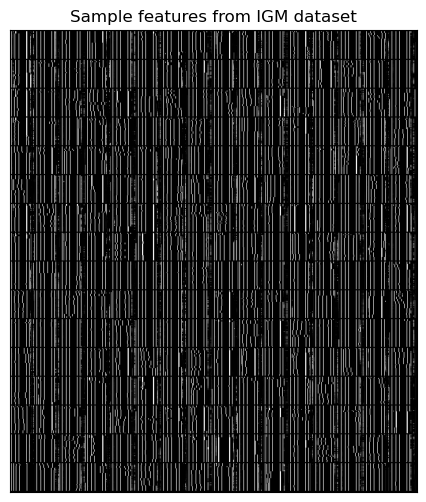

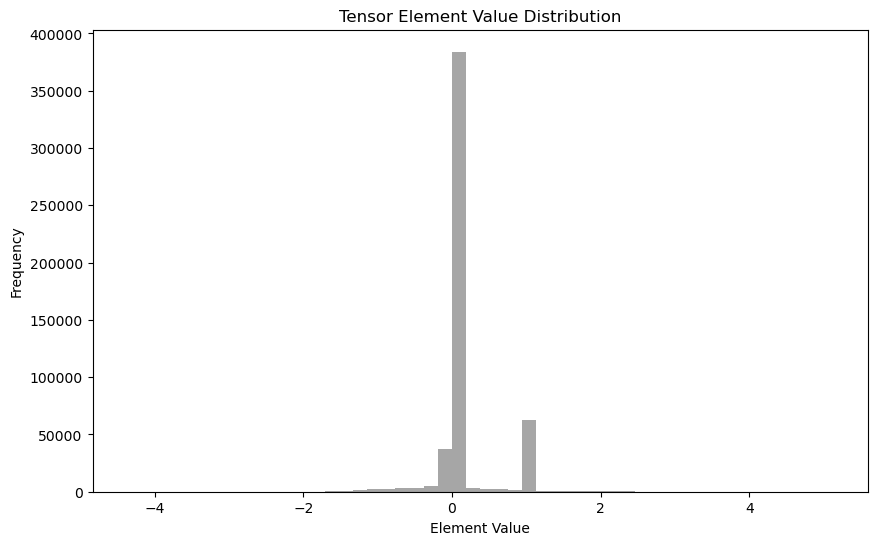

In [7]:
# print some features from IHM dataset just for fun

feats, labels = next(iter(ihm_test_loader))
ihm_feat_shape = feats.shape[1:]
print(f"IHM objective feature shape: {ihm_feat_shape}")
if len(feats.shape) == 3: # if feats is (b, h, w), make it (b, c, h, w) to be able to show
    feats = feats.unsqueeze(1)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample features from IGM dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(feats, nrow=16).permute(1, 2, 0))
plt.show()

# plot tensor value distribution
# Convert feat_syn to a numpy array if it's not already
feats_np = feats.cpu().numpy()
# Reshape the array to a 1D array for histogram plotting
pixels = feats_np.reshape(-1)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixels, bins=50, color='gray', alpha=0.7)
plt.title('Tensor Element Value Distribution')
plt.xlabel('Element Value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


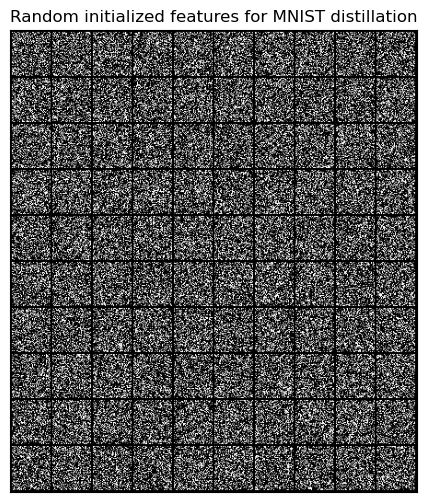

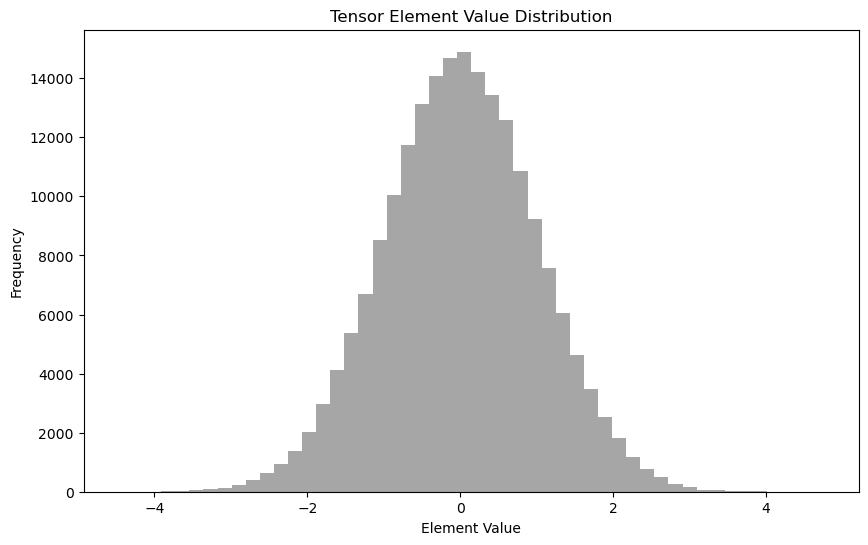

In [8]:
# define synthetic IHM dataset
NUM_SAMPLES_PER_CLS = 50
FROM_REAL_SAMPLES = False

# initialize random synth dataset
if not FROM_REAL_SAMPLES:
    ihm_feat_syn = torch.randn(size=(IHM_NUM_CLS*NUM_SAMPLES_PER_CLS, *ihm_feat_shape), dtype=torch.float, requires_grad=True, device=DEVICE)
    ihm_lab_syn = torch.tensor(np.array([np.ones(NUM_SAMPLES_PER_CLS)*i for i in range(IHM_NUM_CLS)]), dtype=torch.long, requires_grad=False, device=DEVICE).view(-1)
else:
    # Randomly sample features from each class
    sampled_features = {i: ihm_train_set.random_sample_from_class(n_samples=NUM_SAMPLES_PER_CLS, cls=i) for i in range(IHM_NUM_CLS)[0]}
    assert len(sampled_features) == IHM_NUM_CLS
    feature_tensors = []
    label_tensors = []
    for label in sorted(sampled_features.keys()):
        features = sampled_features[label]
        # Stack all features for this class into a single tensor and add to the list
        feature_tensors.append(torch.stack(features))
        # Create a tensor of labels for this class and add to the list
        labels = torch.full((len(features),), label, dtype=torch.long)
        label_tensors.append(labels)
    # Concatenate all class tensors to form the dataset
    ihm_feat_syn = torch.cat(feature_tensors).to(DEVICE)
    ihm_lab_syn = torch.cat(label_tensors).to(DEVICE)
    # Reshape the feature tensor to match the required shape
    ihm_feat_syn = ihm_feat_syn.view(-1, *ihm_feat_shape)
    # require grad for ihm_feat_syn
    ihm_feat_syn.requires_grad_(True)

# print some of the feature tensors
feats = ihm_feat_syn.clone().cpu()
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Random initialized features for MNIST distillation")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(feats.unsqueeze(1), nrow=10).permute(1, 2, 0))
plt.show()

# plot tensor element value distributions
# Convert feat_syn to a numpy array if it's not already
feat_syn_np = ihm_feat_syn.detach().cpu().numpy()
# Reshape the array to a 1D array for histogram plotting
pixels = feat_syn_np.reshape(-1)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixels, bins=50, color='gray', alpha=0.7)
plt.title('Tensor Element Value Distribution')
plt.xlabel('Element Value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

In [9]:
# define get_net

def get_net(name, feat_shape, init=None):
    if name == "1dcnn":
        net = network.IHMPreliminary1DCNN(input_shape=feat_shape, init_distr=init)
    elif name == "mlp":
        net = network.IHMPreliminaryMLP(input_shape=feat_shape, init_distr=init)
    else:
        raise NotImplementedError()
    return net

In [16]:
# distill with gradient matching

OBJECTIVE = ["ihm"][0]

# define local variables
if OBJECTIVE == "ihm":
    feat_shape = ihm_feat_shape
    train_set = ihm_train_set
    test_set = ihm_test_set
    train_loader = ihm_train_loader
    test_loader = ihm_test_loader
    feat_syn = ihm_feat_syn
    lab_syn = ihm_lab_syn
    net_name = "1dcnn"
    continuous_avgs_train, continuous_stds_train, categorical_modes_train = ihm_continuous_avgs_train, ihm_continuous_stds_train, ihm_categorical_modes_train
    num_cls = IHM_NUM_CLS
    comment = ""
else:
    raise NotImplementedError()

# define hyper params
NUM_OUTER_LOOPS = 1000
EVAL_INTERVAL = 100
NUM_EVAL_EPOCHS = 1000
NUM_SAMPLED_NETS_EVAL = 4
LR_DATA = 0.1 # original: 0.1
LR_NET = 0.01 # original: 0.01
NUM_INNER_LOOPS = 10
NUM_UPDT_STEPS_DATA = 1 # s_S
NUM_UPDT_STEPS_NET = 50 # s_theta
BATCH_SIZE_REAL = 256
BATCH_SIZE_SYN = 256

INIT_WEIGHTS_DISTR = [None, "kaiming"][0]
FIX_INIT_WEIGHTS = False

CLAMP_AFTER_EACH_IT = False

MATCH_LOSS = ["gmatch", "mse", "cos"][0]

# define training optimizers and criterion
optimizer_img = torch.optim.SGD([feat_syn,], lr=LR_DATA, momentum=0.5) # optimizer for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss()
print("Ready for training")

# data for plotting curves
eval_its = [] # iterations of evaluation
eval_scores_train = [] # evaluation accuracy on train set
eval_scores_test = [] # evaluation accuracy on test set
avg_losses = []
min_avg_loss = float('inf')

# checkpoints saving
CHECKPOINT_SAVE_DIR = "./saved_data/ihmdd/"
if not os.path.exists(CHECKPOINT_SAVE_DIR):
    os.makedirs(CHECKPOINT_SAVE_DIR)

# snapshots of synthetic data evaluated
feat_syn_snapshots = []

# proposed match loss distance
def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis
    
pbar = tqdm(range(NUM_OUTER_LOOPS+1), desc="Training iteration")
for it in pbar:

    # evaluate the distilled data every `EVAL_INTERVAL` iterations
    if EVAL_INTERVAL > 0 and it % EVAL_INTERVAL == 0:
        eval_its.append(it)

        print(f"Optimization iteration {it} evaluation begins...")
        feat_syn_snapshot = feat_syn.detach().clone()
        feat_syn_snapshots.append(feat_syn_snapshot)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.title(f"Synthetic dataset (optimization iteration {it})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(feat_syn_snapshot.cpu().unsqueeze(1), nrow=10).permute(1, 2, 0))
        plt.show()

        # sample a batch of models to eval on
        sampled_nets = []
        local_train_scores = []
        local_test_scores = []
        for j in range(NUM_SAMPLED_NETS_EVAL if not FIX_INIT_WEIGHTS else 1):
            if FIX_INIT_WEIGHTS:
                torch.random.manual_seed(42) # fixed seed
            else:
                torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            net = get_net(net_name, feat_shape=input_shape, init=INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_nets.append(net)
        for j, net in enumerate(sampled_nets):
            print(f"Training network {j} for evaluation...")
            net.train()
            optimizer = torch.optim.SGD(net.parameters(), lr=LR_NET)
            # train the models on synthetic set
            for s in range(NUM_EVAL_EPOCHS):
                pred_syn = net(feat_syn_snapshot)
                loss_syn = criterion(pred_syn, lab_syn)
                optimizer.zero_grad()
                loss_syn.backward()
                optimizer.step()
        for j, net in enumerate(sampled_nets):
            print(f"Testing network {j} on real datasets for evaluation...")
            # evaluate the models on both full train set and test set
            train_score = report.compute_roc_auc_score(net, train_loader)
            test_score = report.compute_roc_auc_score(net, test_loader)
            local_train_scores.append(train_score)
            local_test_scores.append(test_score)
        eval_scores_train.append(sum(local_train_scores) / len(local_train_scores))
        eval_scores_test.append(sum(local_test_scores) / len(local_test_scores))
        print(f"Optimization iteration {it}, eval auroc score (train): {eval_scores_train[-1]:.4f}, eval auroc score (test): {eval_scores_test[-1]:.4f}")
    
    checkpoint = {
        "objective": OBJECTIVE,
        "method": "gmatch",
        "it": it,
        "num_cls": num_cls,
        "feat_syn": feat_syn.detach().clone(),
        "lab_syn": lab_syn.detach().clone(),
        'optim_losses': avg_losses,
        "eval_its": eval_its,
        "feat_syn_snapshots": feat_syn_snapshots,
        'eval_scores_train': eval_scores_train,
        'eval_scores_test': eval_scores_test,
        'init_weight_distr': INIT_WEIGHTS_DISTR,
        'fix_init_weights': FIX_INIT_WEIGHTS,
        "comment": comment
    }
    
    # Save checkpoint
    filepath = os.path.join(CHECKPOINT_SAVE_DIR, f'gmatch_{OBJECTIVE}_{"sample" if FROM_REAL_SAMPLES else "noise"}.pth')
    torch.save(checkpoint, filepath)
    print(f"Checkpoint at iteration {it} saved at {filepath}")
    
    if it >= NUM_OUTER_LOOPS: # last epoch only evaluate, no training
        break

    # Train synthetic data
    if FIX_INIT_WEIGHTS:
        torch.random.manual_seed(42) # fixed seed
    else:
        torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
    net = get_net(net_name, feat_shape=input_shape, init=INIT_WEIGHTS_DISTR).to(DEVICE)
    net.train()
    net_params = list(net.parameters())

    optimizer_net = torch.optim.SGD(net.parameters(), lr=LR_NET)
    optimizer_net.zero_grad()
    loss_avg = 0

    for l in range(NUM_INNER_LOOPS):
        # update synthetic data
        loss = torch.tensor(0.0).to(DEVICE)
        for cls in range(num_cls):
            sampled_real_feats, _ = train_set.random_sample_from_class(n_samples=BATCH_SIZE_REAL, cls=cls)
            cls_feat_real = torch.stack(sampled_real_feats).to(DEVICE)
            cls_lab_real = torch.full((len(sampled_real_feats),), cls, dtype=torch.long).to(DEVICE)
            cls_feat_syn = feat_syn[cls*NUM_SAMPLES_PER_CLS: (cls+1)*NUM_SAMPLES_PER_CLS]
            cls_lab_syn = lab_syn[cls*NUM_SAMPLES_PER_CLS: (cls+1)*NUM_SAMPLES_PER_CLS]

            out_real = net(cls_feat_real)
            loss_real = criterion(out_real, cls_lab_real)
            grad_real = torch.autograd.grad(loss_real, net_params)
            grad_real = list((_.detach().clone() for _ in grad_real))

            out_syn = net(cls_feat_syn)
            loss_syn = criterion(out_syn, cls_lab_syn)
            grad_syn = torch.autograd.grad(loss_syn, net_params, create_graph=True) # create_graph: will be used to compute higher-order derivatives

            dis = torch.tensor(0.0).to(DEVICE)

            if MATCH_LOSS == "gmatch":
                for gidx in range(len(grad_real)):
                    gr = grad_real[gidx]
                    gs = grad_syn[gidx]
                    dis += distance_wb(gr, gs)
            elif MATCH_LOSS == "mse":
                # compute gradient matching loss, here using MSE, instead of the one proposed in DCwMG because it's too complicated
                # dis = torch.tensor(0.0).to(DEVICE)
                grad_real_vec = []
                grad_syn_vec = []
                for gidx in range(len(grad_real)):
                    grad_real_vec.append(grad_real[gidx].reshape((-1)))
                    grad_syn_vec.append(grad_syn[gidx].reshape((-1)))
                grad_real_vec = torch.cat(grad_real_vec, dim=0)
                grad_syn_vec = torch.cat(grad_syn_vec, dim=0)
                dis = torch.sum((grad_syn_vec - grad_real_vec)**2)
            else:
                raise NotImplementedError()

            loss += dis
        
        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        # print(f"It = {it}, synthetic image pixels are now distributed within [{torch.min(feat_syn)}, {torch.max(feat_syn)}]")
        
        if CLAMP_AFTER_EACH_IT:
            with torch.no_grad():
                # Clamp the values of the tensor to the range [-1, 1]
                feat_syn.clamp_(-1, 1) # this is not in the original paper, where the image is only clamped before visualized

        # update network
        feat_syn_train, lab_syn_train = copy.deepcopy(feat_syn.detach()), copy.deepcopy(lab_syn.detach())  # avoid any unaware modification
        for s in range(NUM_UPDT_STEPS_NET):
            pred_syn_train = net(feat_syn_train)
            train_loss = criterion(pred_syn_train, lab_syn_train)
            optimizer_net.zero_grad()
            train_loss.backward()
            optimizer_net.step()

    loss_avg /= (2 * NUM_INNER_LOOPS)
    pbar.set_postfix({"avg loss": f"{loss_avg:.4f}",
                      })
    avg_losses.append(loss_avg)
    if loss_avg < min_avg_loss:
        min_avg_loss = loss_avg
        print(f"New best at iteratoin {it}!")


Ready for training


Training iteration:   0%|          | 0/1001 [00:00<?, ?it/s]

Checkpoint at iteration 0 saved at ./saved_data/ihmdd/gmatch_ihm_noise.pth
New best at iteratoin 0!
Checkpoint at iteration 1 saved at ./saved_data/ihmdd/gmatch_ihm_noise.pth
New best at iteratoin 1!
Checkpoint at iteration 2 saved at ./saved_data/ihmdd/gmatch_ihm_noise.pth


KeyboardInterrupt: 